# Einfaches Transportproblem

Wir implementieren hier ein einfaches Transportproblem.

Eine Menge  $\mathcal B$ von Produktionsstätten und eine Menge $\mathcal C$ von Kunden ist gegeben. 
Die Produktionsstätte $i\in\mathcal B$ kann während der 
Produktionsperiode $a_i$kg *Frosted Sugar Flakes* herstellen. Der Kunde $j\in\mathcal C$ 
möchte in dieser Zeit die Menge $d_j$ (wieder in kg) abnehmen. Die Produktionsstätten
sind unterschiedlich effizient. Es kostet daher $b_i$€ um ein Kilogramm *Frosted Sugar Flakes*
in der Produktionsstätte $i\in\mathcal B$ herzustellen. Der Transport von $i\in\mathcal B$
pro Kilogramm zum Kunden $j\in\mathcal C$ schlägt mit $c_{ij}$€ zu Buche.
Welche Produktionsstätte soll nun welchen Kunden mit wie viel Produkt beliefern, so dass die Gesamtkosten
möglichst gering sind?

Als lineares Programm:
$$
\begin{array}{lll}
\min & \sum_{i\in\mathcal B}\sum_{j\in\mathcal C}b_ix_{ij}+c_{ij}x_{ij} &\\
\text{unter} & \sum_{j\in\mathcal C}x_{ij}\leq a_i&\quad\text{für alle }i\in\mathcal B\\
&\sum_{i\in\mathcal B}x_{ij}=d_j&\quad\text{für alle }j\in\mathcal C
\end{array}
$$

In [1]:
# Zum Installieren in google colab, entfernen Sie die Raute in der nächsten Zeile
#!pip install mip

import mip
import random  ## Standard-Bibliothek zur Erzeugung von Zufallszahlen
import math

### Wir werden die Daten plotten und müssen dafür matplotlib einbinden
import matplotlib.pyplot as plt
### Wir benutzen das fivethirtyeight style, damit die plots ein bisschen hübscher aussehen
plt.style.use('fivethirtyeight')

Wie immer brauchen wir eine Beispielsinstanz, die wir zufällig erzeugen. Wir platzieren Produktionsstätten und Kunden zufällig in der Ebene. Als Transportkosten nehmen wir dann den gewöhnlichen Abstand in der Ebene.

In [2]:
def rnd_instance(num_factories=3,num_customers=10):
    factories=[(random.random(),random.random()) for _ in range(num_factories)]
    customers=[(random.random(),random.random()) for _ in range(num_customers)]
    demands=[0.5+random.random() for _ in range(num_customers)]  
    total_demand=sum(demands)
    supply_factor=total_demand/num_factories
    ### wir stellen sicher, dass die Nachfrage abgedeckt werden kann
    insufficient_supply=True
    while insufficient_supply:
        supplies=[0.3*supply_factor+random.random()*1.1*supply_factor for _ in range(num_factories)]
        if sum(supplies)>=total_demand:
            insufficient_supply=False
    return factories,customers,supplies,demands

def distance(factory,customer):
    px,py=factory
    qx,qy=customer
    return math.sqrt((px-qx)**2+(py-qy)**2)

In [3]:
num_factories=3
num_customers=10
B,C,a,d=rnd_instance(num_factories=num_factories,num_customers=num_customers)

Stellen wir das LP auf. Als Variablen benötigen wir nur die Transportvariablen $x_{ij}$.

In [4]:
m=mip.Model()
x=[[m.add_var() for _ in range(num_customers)] for _ in range(num_factories)]

Wir stellen sicher, dass keine Produktionsstätte mehr produziert, als sie kann:

In [5]:
for i in range(num_factories):
    m+=mip.xsum(x[i][j] for j in range(num_customers))<=a[i]

...und wir erzwingen, dass der Bedarf jedes Kunden gedeckt wird:

In [6]:
for j in range(num_customers):
    m+=mip.xsum(x[i][j] for i in range(num_factories))==d[j]

Die Zielfunktion besteht einfach aus den Transportkosten. Der Einfachheit halber lassen wir die Produktionskosten weg, bzw. nehmen an, dass die 
Produktionskosten in allen Produktionsstätten gleich sind.

In [7]:
m.objective=mip.minimize(mip.xsum(x[i][j]*distance(B[i],C[j]) for i in range(num_factories) for j in range(num_customers)))
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

Wir plotten das Ergebnis.

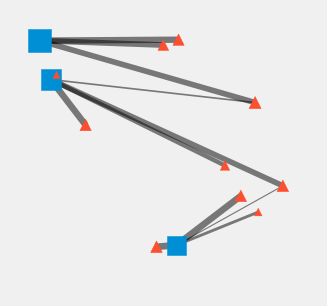

In [8]:
import numpy as np
plt.figure(figsize=(5,5))
BB=np.array(B)
CC=np.array(C)
plt.scatter(BB[:,0],BB[:,1],s=np.array(a)*100,marker='s')
plt.scatter(CC[:,0],CC[:,1],s=np.array(d)*100,marker='^')
for i in range(num_factories):
    for j in range(num_customers):
        if x[i][j].x>0.0001:
            plt.plot([BB[i,0],CC[j,0]],[BB[i,1],CC[j,1]],'k',zorder=-1,alpha=0.5,linewidth=x[i][j].x*5)
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xticks([])
plt.yticks([])
plt.show()

Im Plot sind die Produktionsstätten als Quadrate, die Kunden als Dreiecke widergegeben. Die Größen (Durchmesser) spiegeln den Bedarf/die Nachfrage wider. Ebenso ist die Linienstärke der Verbindungen proportional zum Transport.